In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 37.1 MB/s eta 0:00:00


In [ ]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import numpy as np

import matplotlib.pyplot as plt

import pytorch_lightning as pl

import random

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [ ]:

import random
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from torchvision import transforms

class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=64, num_workers=4, mislabel_percentage=0.1):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.mislabel_percentage = mislabel_percentage

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)

            # Mislabel 10% of the training data
            self._mislabel(mnist_full)

            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def _mislabel(self, dataset):
        num_mislabel = int(self.mislabel_percentage * len(dataset))
        indices = random.sample(range(len(dataset)), num_mislabel)

        for idx in indices:
            # Replace the label with a random incorrect label
            original_label = dataset.targets[idx].item()  # Access label using targets
            new_label = random.choice([i for i in range(10) if i != original_label])
            dataset.targets[idx] = new_label  # Modify the label directly in targets

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

    def get_labels(self):
        return list(range(10))  # MNIST has 10 classes (0-9)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6073855.54it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 160285.62it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1014530.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5544391.38it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



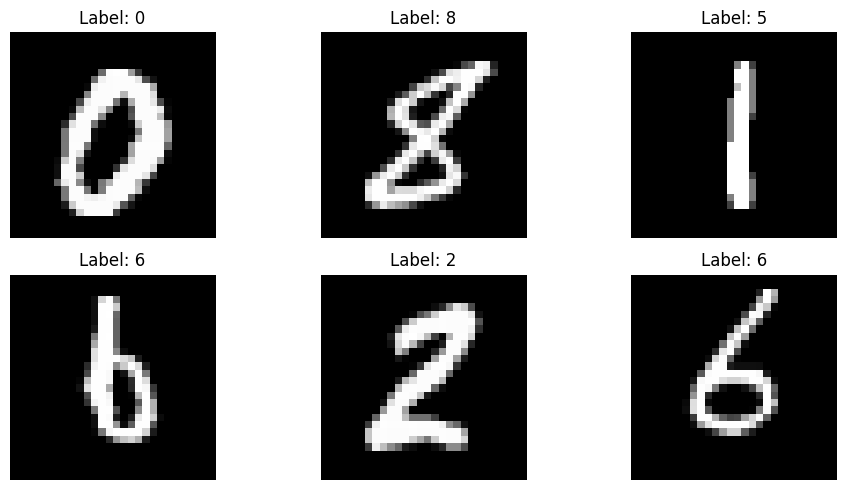

In [ ]:
def show_sample_images(data_module, num_samples=6):
    # Get a batch of training data
    train_loader = data_module.train_dataloader()
    images, labels = next(iter(train_loader))  # Get the first batch

    # Select a few random samples to display
    indices = np.random.choice(len(images), num_samples, replace=False)
    sample_images = images[indices]
    sample_labels = labels[indices]

    # Plotting
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(2, 3, i + 1)
        plt.imshow(sample_images[i].cpu().numpy()[0], cmap='gray')
        plt.title(f"Label: {sample_labels[i].item()}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
mnist_data_module = MNISTDataModule()  # Initialize your data module
mnist_data_module.prepare_data()  # Download the data
mnist_data_module.setup()  # Set up the data
show_sample_images(mnist_data_module)  # Display sample images

In [ ]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320 + num_classes, 50)  # Adjusted input size for labels
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x, labels):
        # Process the images through the CNN layers
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # Flatten the tensor
        x = x.view(-1, 320)

        # One-hot encode the labels
        labels = F.one_hot(labels, num_classes=self.num_classes).float()

        # Concatenate the flattened image features with the labels
        x = torch.cat((x, labels), dim=1)  # Concatenate along the feature dimension

        # Pass through the fully connected layers
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return torch.sigmoid(x)

In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes=10):
        super().__init__()
        self.num_classes = num_classes

        # Linear layer to project the latent space + label space
        self.lin1 = nn.Linear(latent_dim + num_classes, 7 * 7 * 64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)  # [n, 32, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)  # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]

    def forward(self, z, labels):

        # TEST
        labels = labels.type(torch.long)

        # One-hot encode the labels
        labels = F.one_hot(labels, num_classes=self.num_classes).float()

        # Concatenate the latent vector with the labels
        x = torch.cat((z, labels), dim=1)  # Concatenate along the feature dimension

        # Pass the combined input into the linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  # Reshape to [n, 64, 7, 7]

        # Upsample (transposed conv) to 16x16 (32 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [ ]:
class CGAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()

        self.generator = ConditionalGenerator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        # Random noise for validation
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

        self.automatic_optimization = False

    def forward(self, z, labels):  # Now expects both z and labels
        return self.generator(z, labels)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        real_imgs, labels = batch  # Unpack labels

        # Get optimizers
        g_opt, d_opt = self.optimizers()

        # ----------------------
        # Train Generator
        # ----------------------
        z = torch.randn(real_imgs.size(0), self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        # Generate fake images
        fake_imgs = self(z, labels)  # Pass both z and labels to generator
        y_hat_fake = self.discriminator(fake_imgs, labels)  # Pass labels to discriminator

        # Label for fake images is 1 (for generator loss)
        g_loss = self.adversarial_loss(y_hat_fake, torch.ones(real_imgs.size(0), 1).type_as(real_imgs))

        # Update generator
        g_opt.zero_grad()
        self.manual_backward(g_loss)
        g_opt.step()

        # ----------------------
        # Train Discriminator
        # ----------------------
        # Real images
        y_hat_real = self.discriminator(real_imgs, labels)  # Pass labels to discriminator
        real_loss = self.adversarial_loss(y_hat_real, torch.ones(real_imgs.size(0), 1).type_as(real_imgs))

        # Fake images (detach to avoid backprop to generator)
        y_hat_fake = self.discriminator(fake_imgs.detach(), labels)  # Pass labels to discriminator
        fake_loss = self.adversarial_loss(y_hat_fake, torch.zeros(real_imgs.size(0), 1).type_as(real_imgs))

        d_loss = (real_loss + fake_loss) / 2

        # Update discriminator
        d_opt.zero_grad()
        self.manual_backward(d_loss)
        d_opt.step()

        # Logging
        log_dict = {"g_loss": g_loss, "d_loss": d_loss}
        self.log_dict(log_dict, prog_bar=True)

        if (batch_idx + 1) == self.trainer.num_training_batches:
          print(f"End of epoch {self.current_epoch}, calling plot_imgs()")
          self.plot_imgs()

    def configure_optimizers(self):
        lr = self.hparams.lr
        g_opt = torch.optim.Adam(self.generator.parameters(), lr=lr)
        d_opt = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [g_opt, d_opt], []

    def plot_imgs(self):
        num_classes = 10  # Number of classes in MNIST
        num_samples_per_class = 6  # Number of samples to generate for each class
        fig = plt.figure(figsize=(10, 10))

        for class_label in range(num_classes):
            # Sample random noise
            z = torch.randn(num_samples_per_class, self.hparams.latent_dim).type_as(self.generator.lin1.weight)

            # Create labels for the sampled images
            labels = torch.full((num_samples_per_class,), class_label, dtype=torch.long).type_as(self.generator.lin1.weight)

            # Generate images using the generator
            sample_imgs = self.generator(z, labels).cpu().detach()  # Detach here

            for i in range(num_samples_per_class):
                plt.subplot(num_classes, num_samples_per_class, class_label * num_samples_per_class + i + 1)
                plt.imshow(sample_imgs[i, 0, :, :].detach().numpy(), cmap='gray_r', interpolation='none')  # Detach and convert to numpy
                plt.title(f"Label: {class_label}")
                plt.axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
dm = MNISTDataModule(batch_size=64)
model=CGAN()

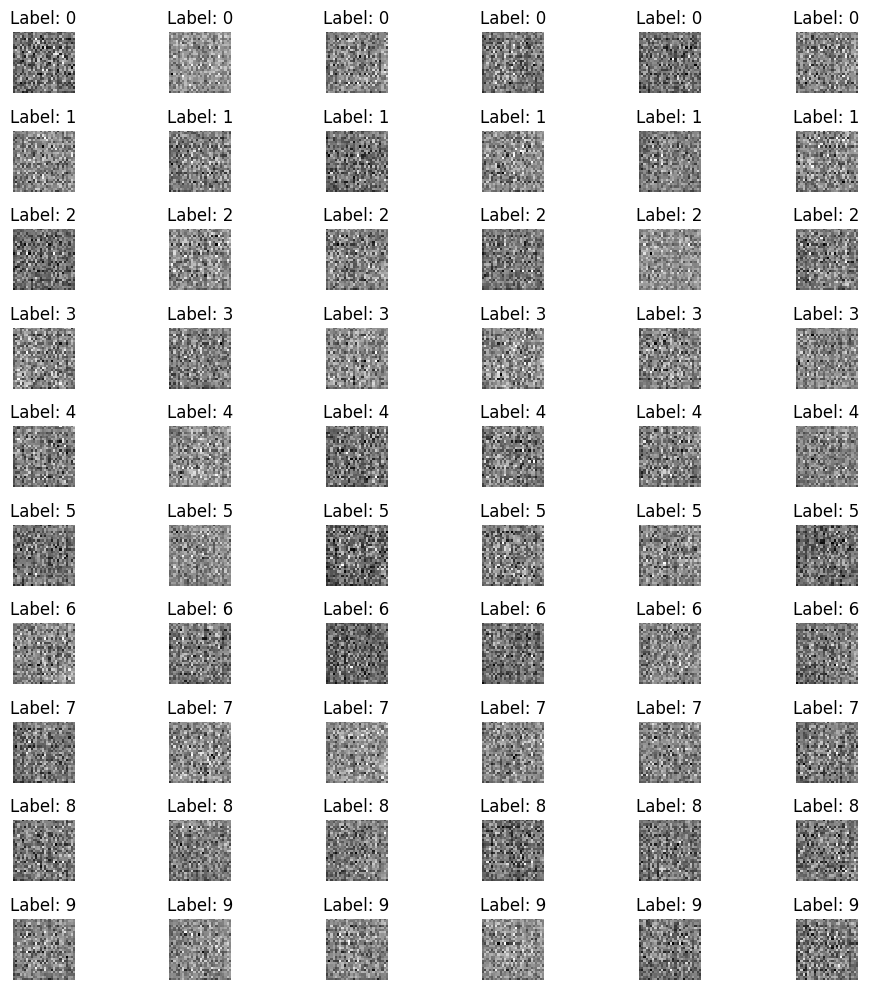

In [ ]:
model.plot_imgs()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                 | Params | Mode 
---------------------------------------------------------------
0 | generator     | ConditionalGenerator | 389 K  | train
1 | discriminator | Discriminator        | 21.9 K | train
---------------------------------------------------------------
411 K     Trainable params
0         Non-trainable params
411 K     Total params
1.647     Total estimated model params size (MB)
11        Mo

Training: |          | 0/? [00:00<?, ?it/s]

End of epoch 0, calling plot_imgs()


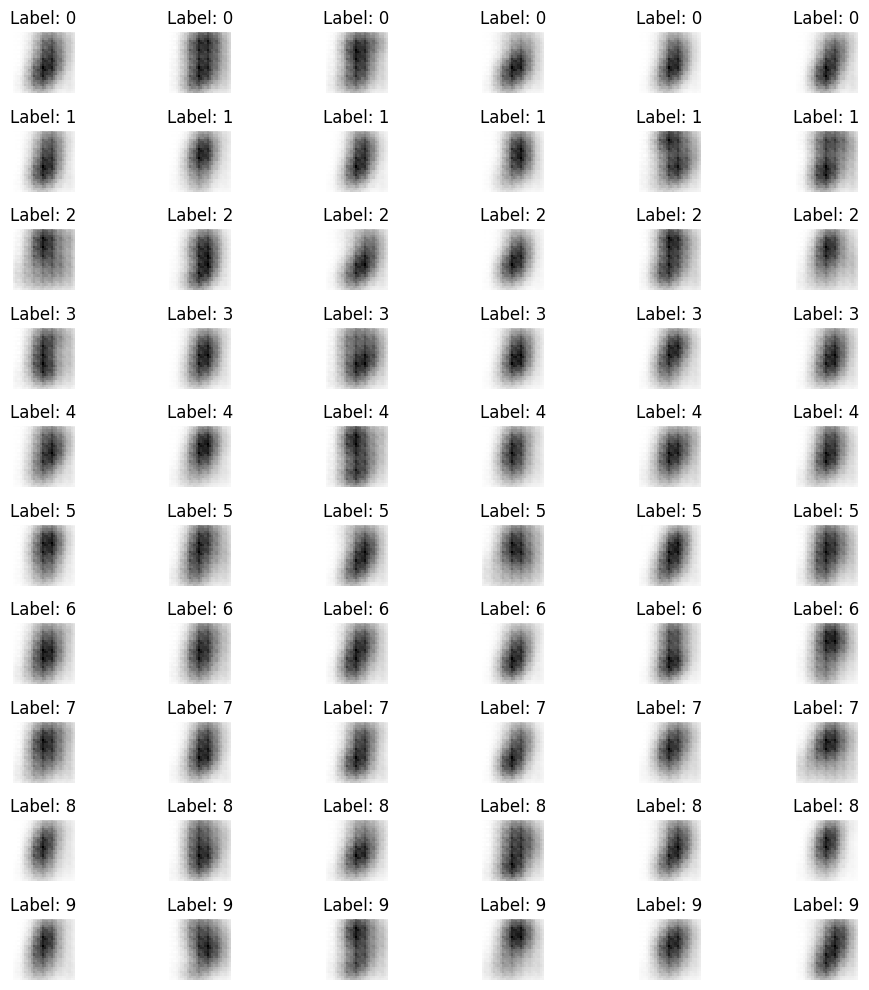

End of epoch 1, calling plot_imgs()


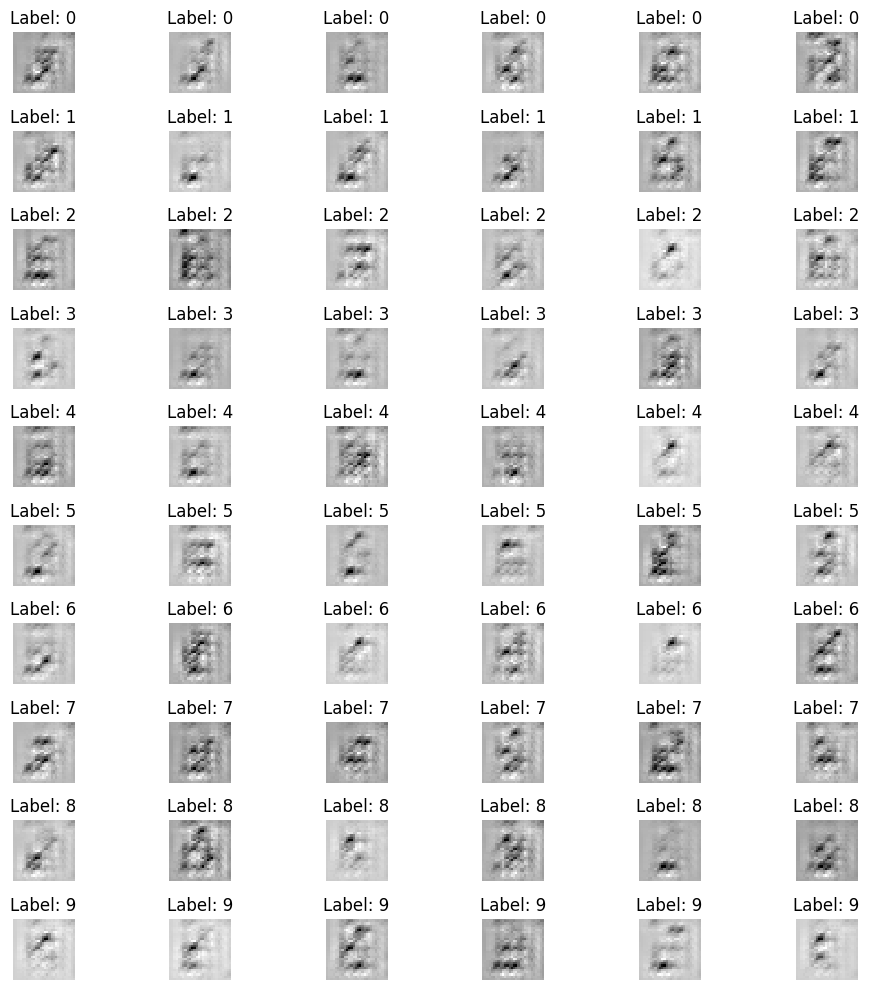

End of epoch 2, calling plot_imgs()


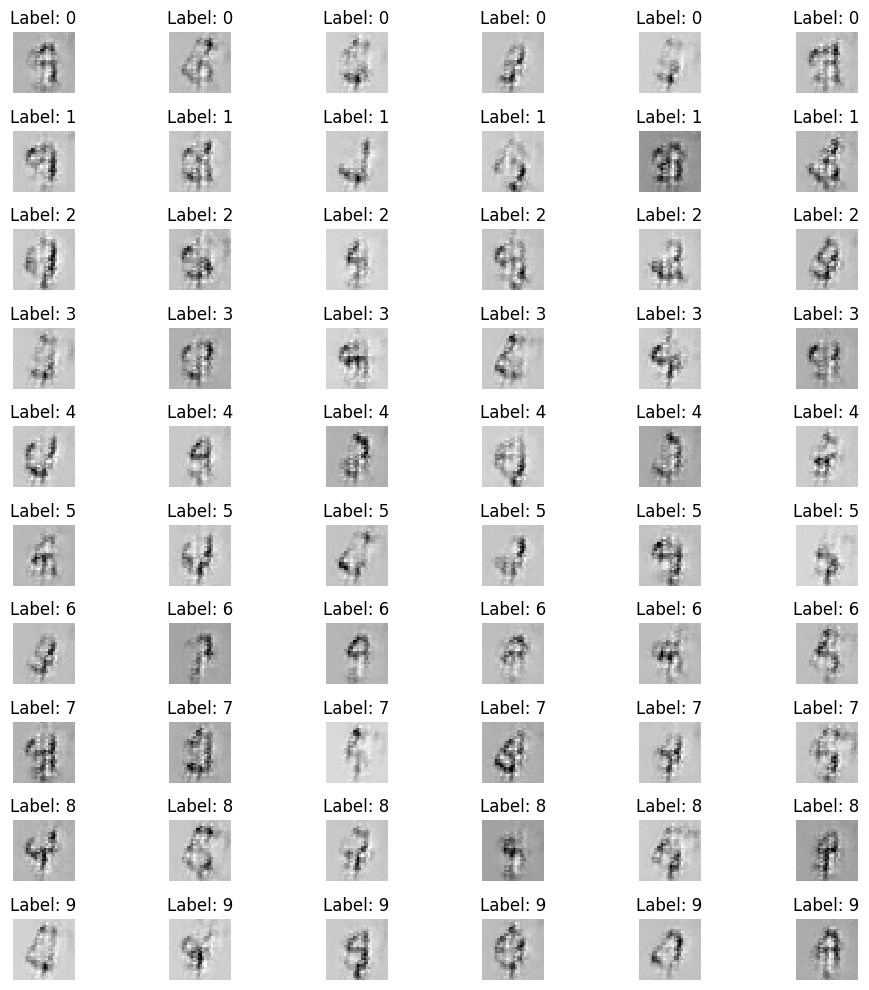

End of epoch 3, calling plot_imgs()


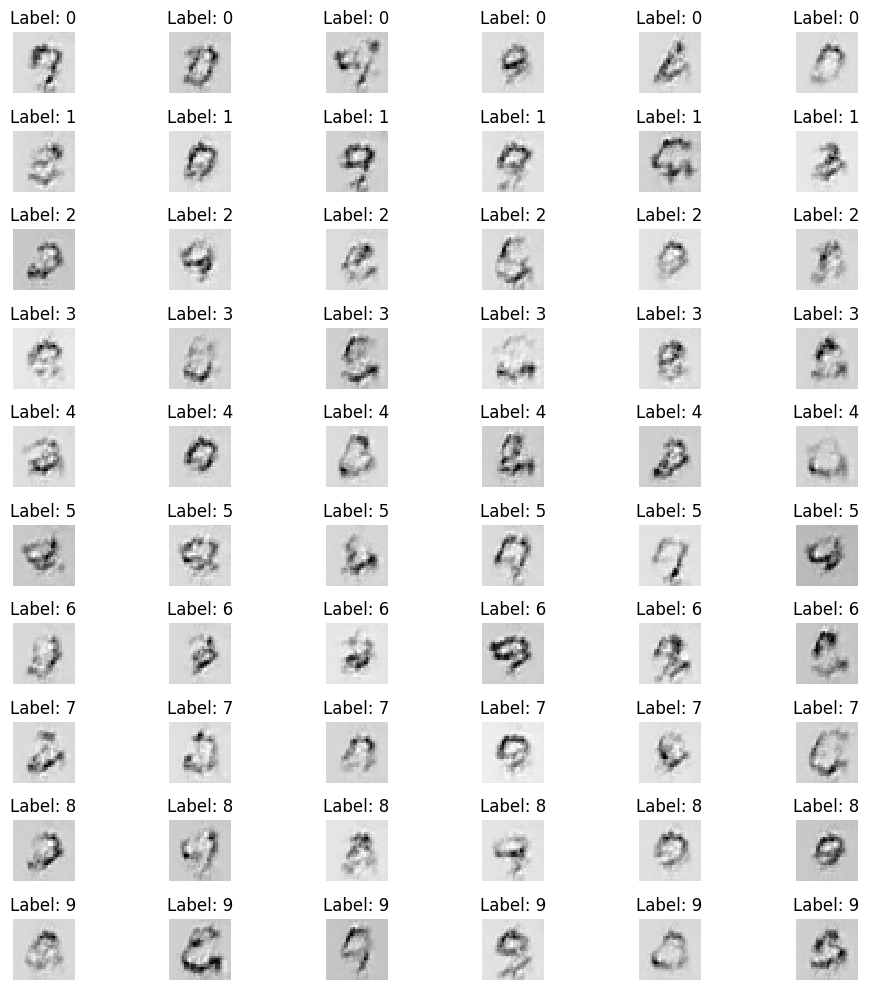

End of epoch 4, calling plot_imgs()


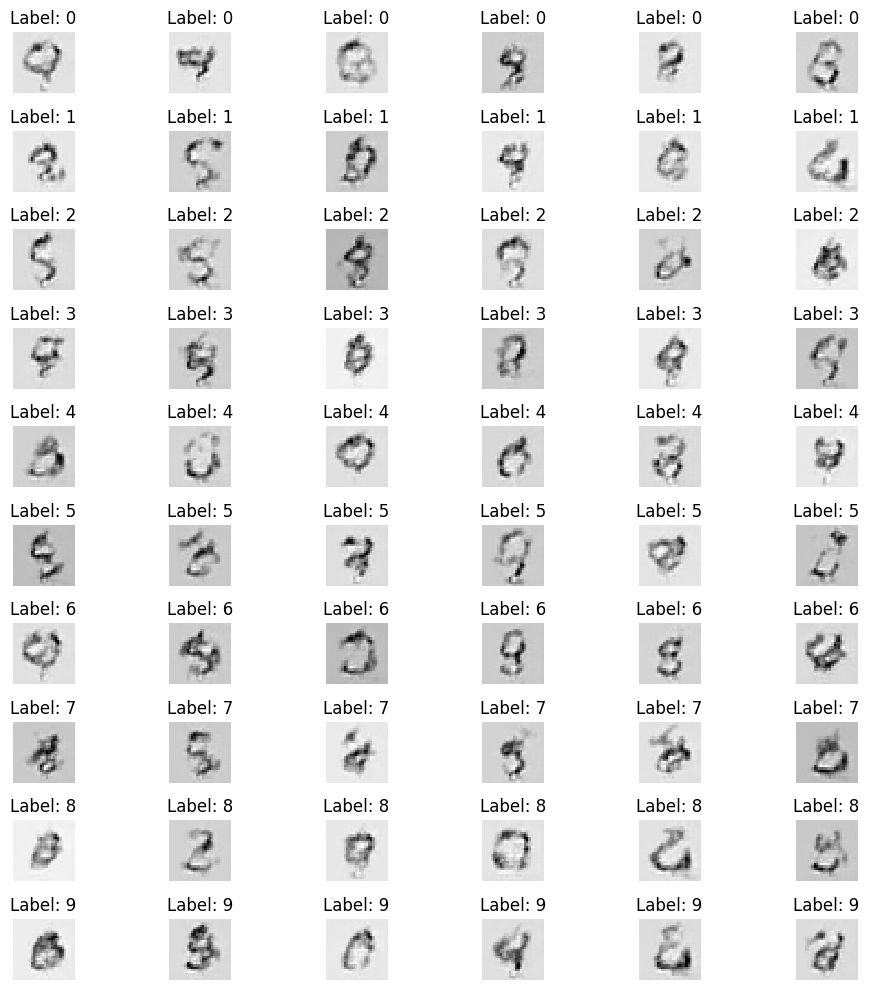

End of epoch 5, calling plot_imgs()


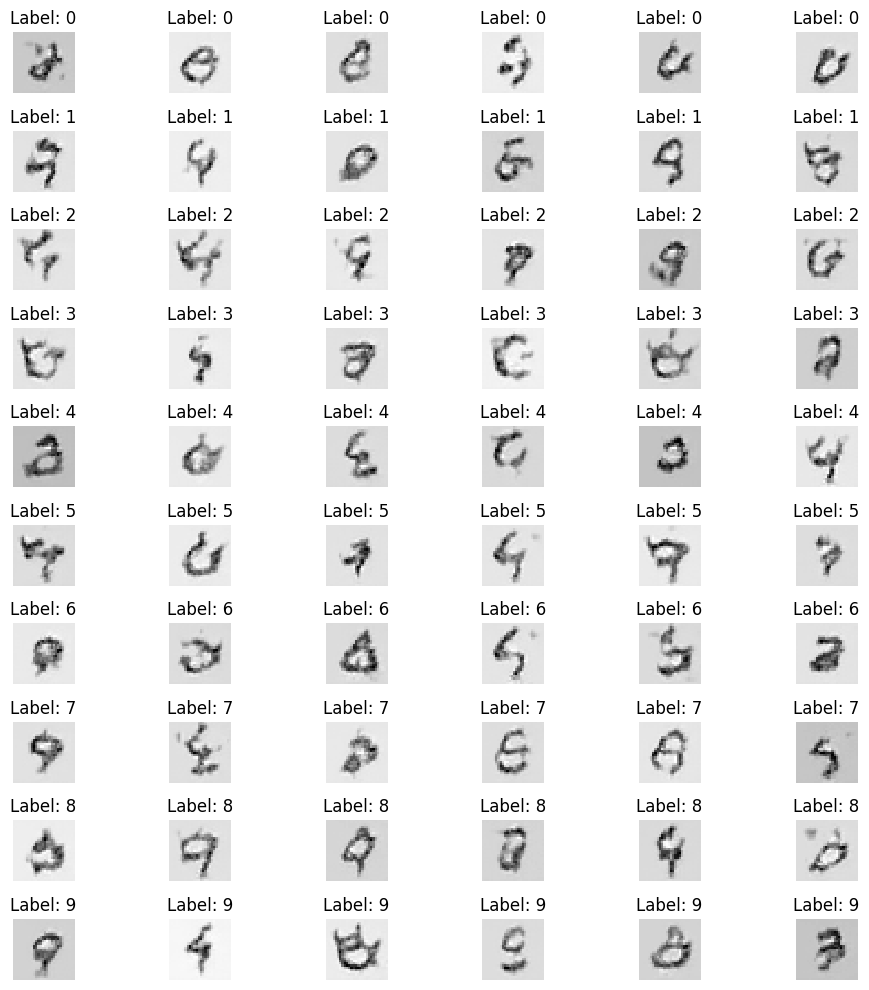

End of epoch 6, calling plot_imgs()


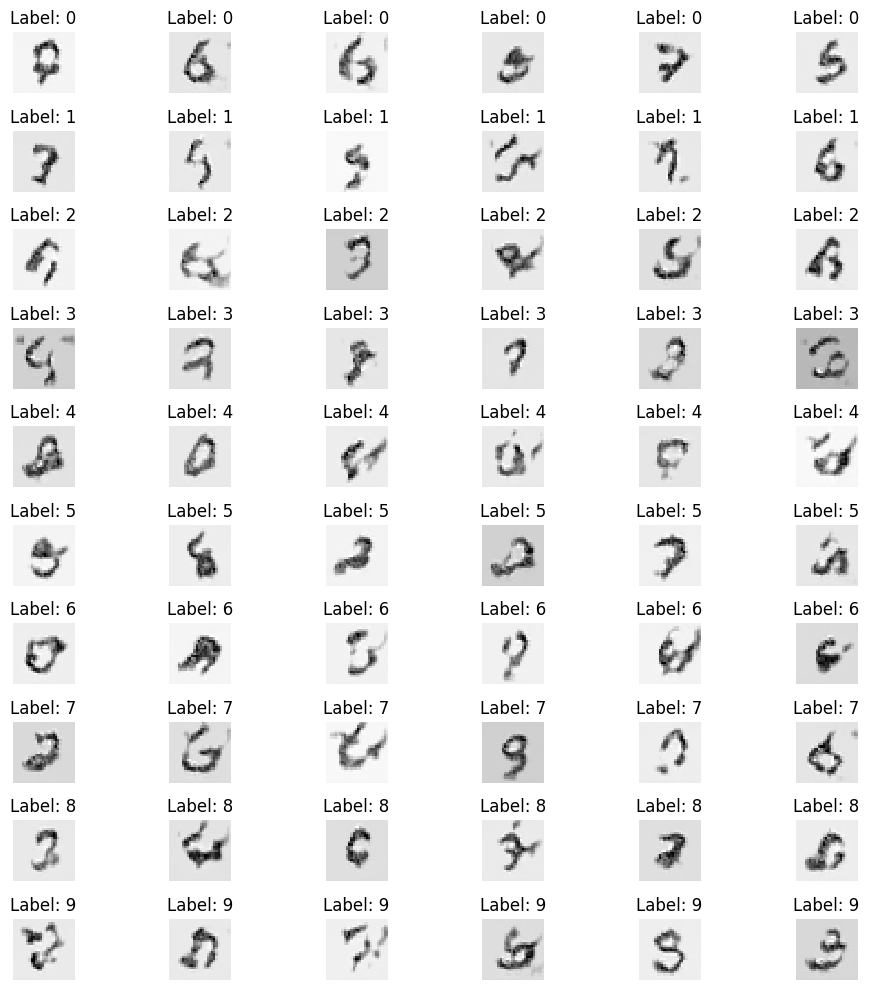

End of epoch 7, calling plot_imgs()


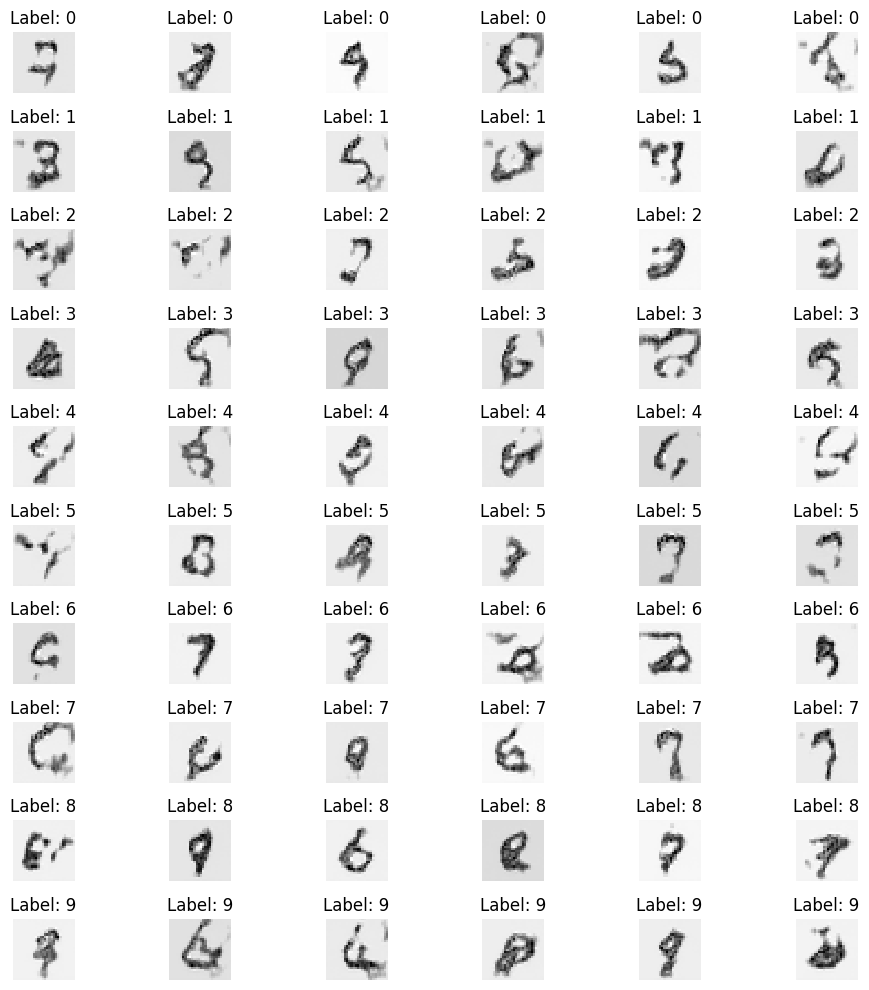

End of epoch 8, calling plot_imgs()


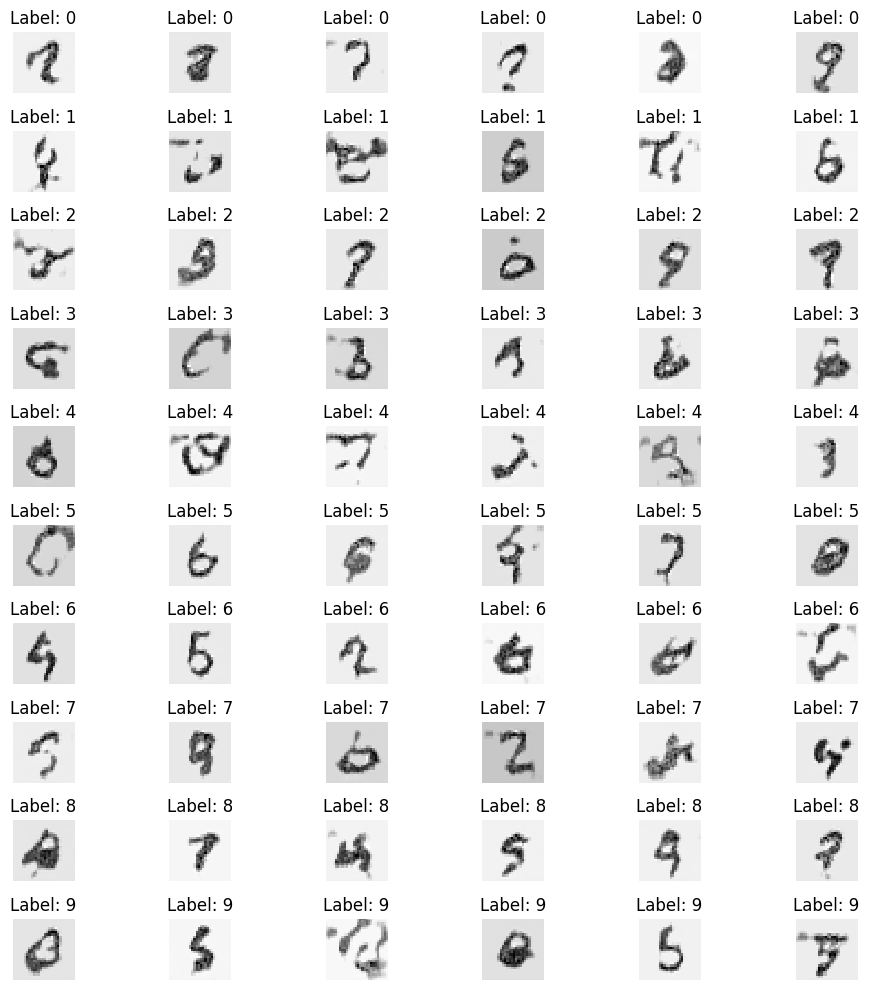

End of epoch 9, calling plot_imgs()


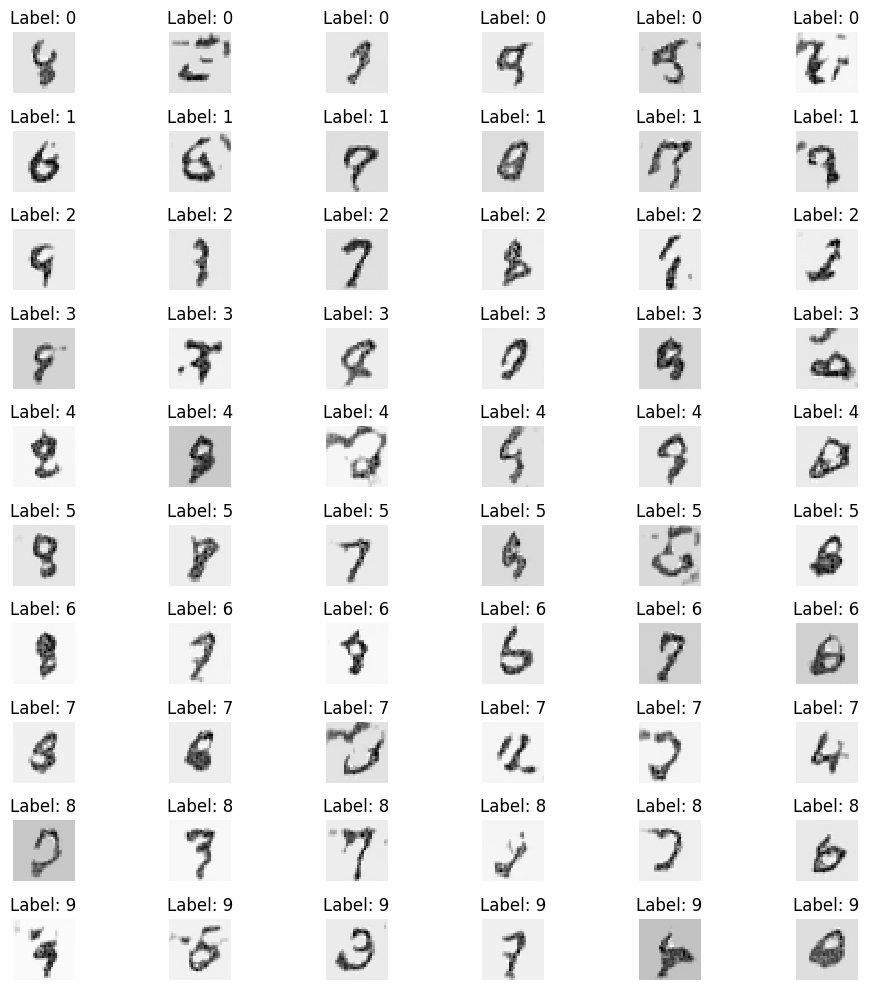

End of epoch 10, calling plot_imgs()


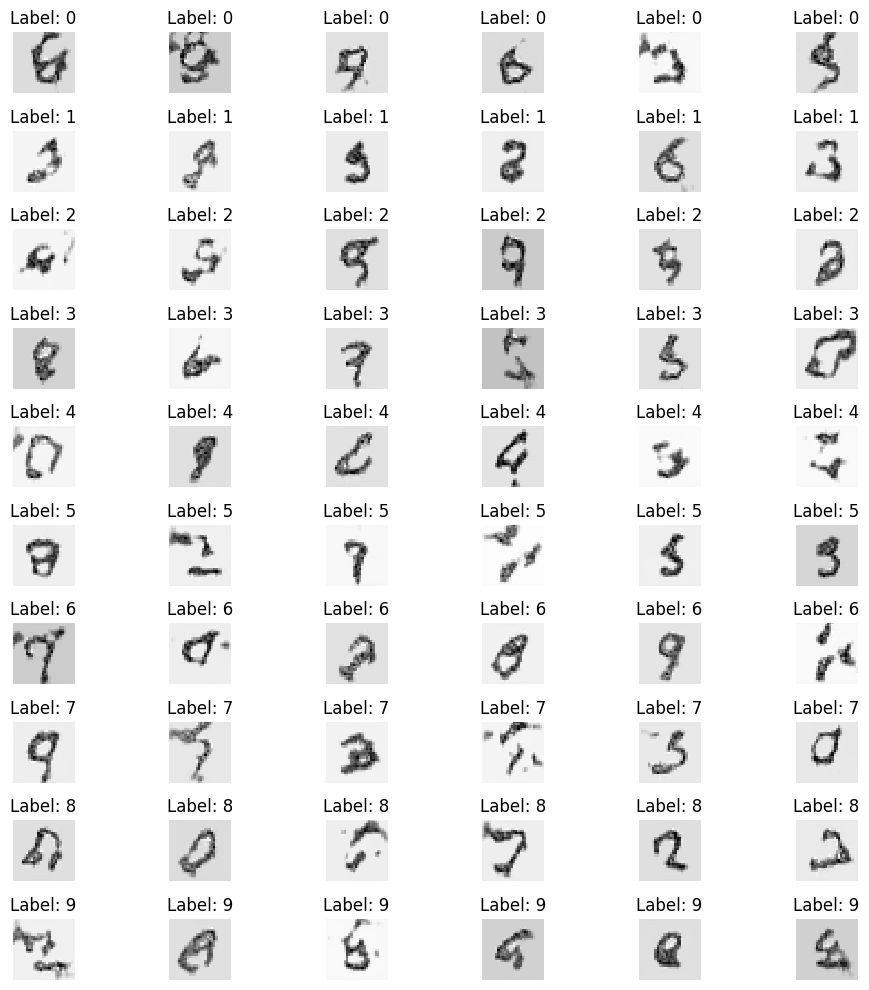

End of epoch 11, calling plot_imgs()


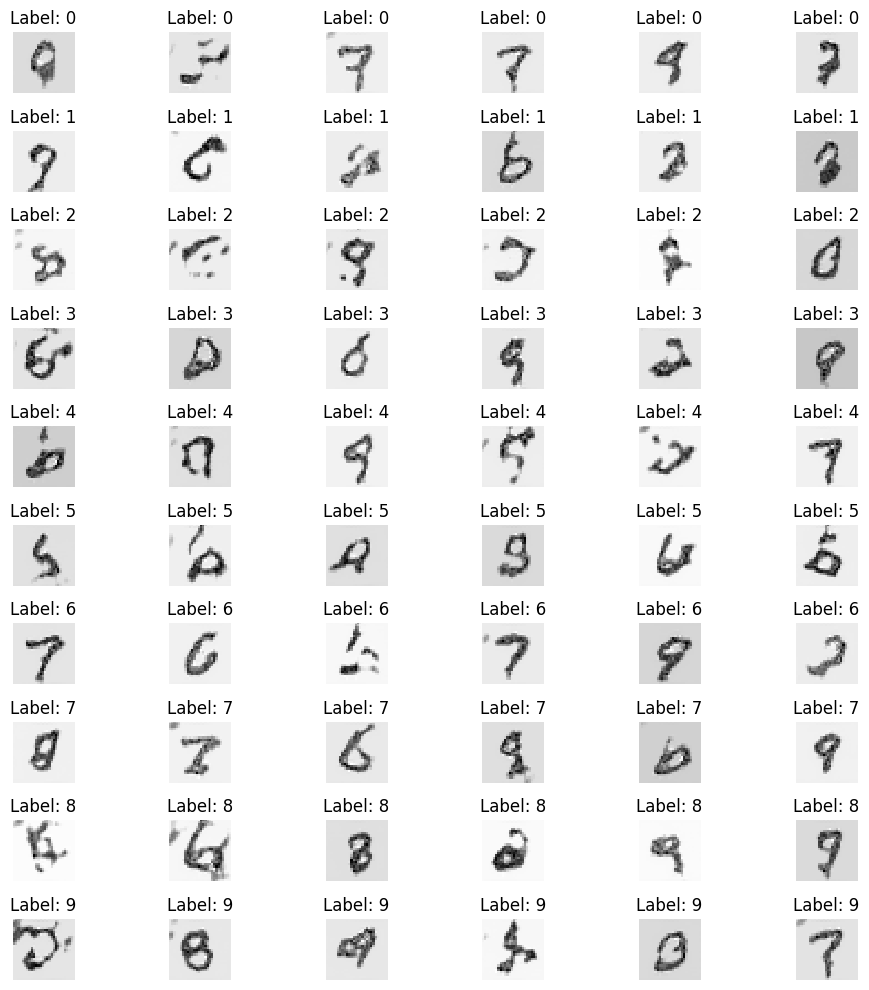

End of epoch 12, calling plot_imgs()


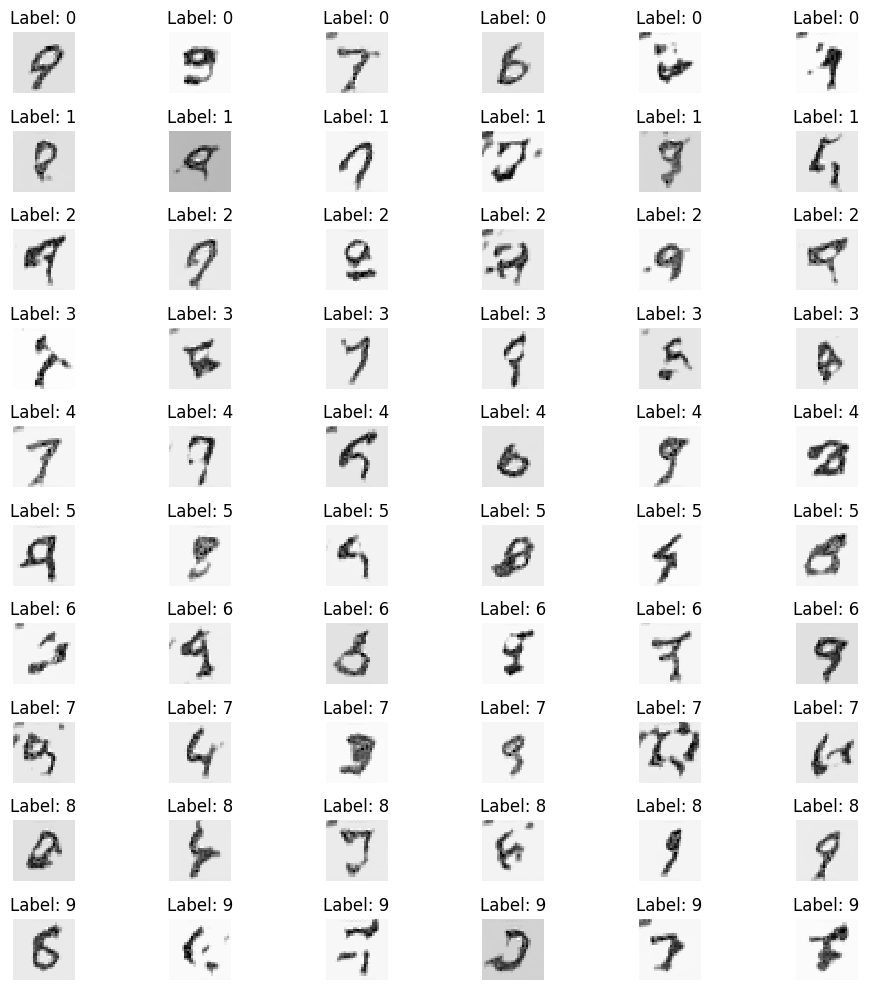

End of epoch 13, calling plot_imgs()


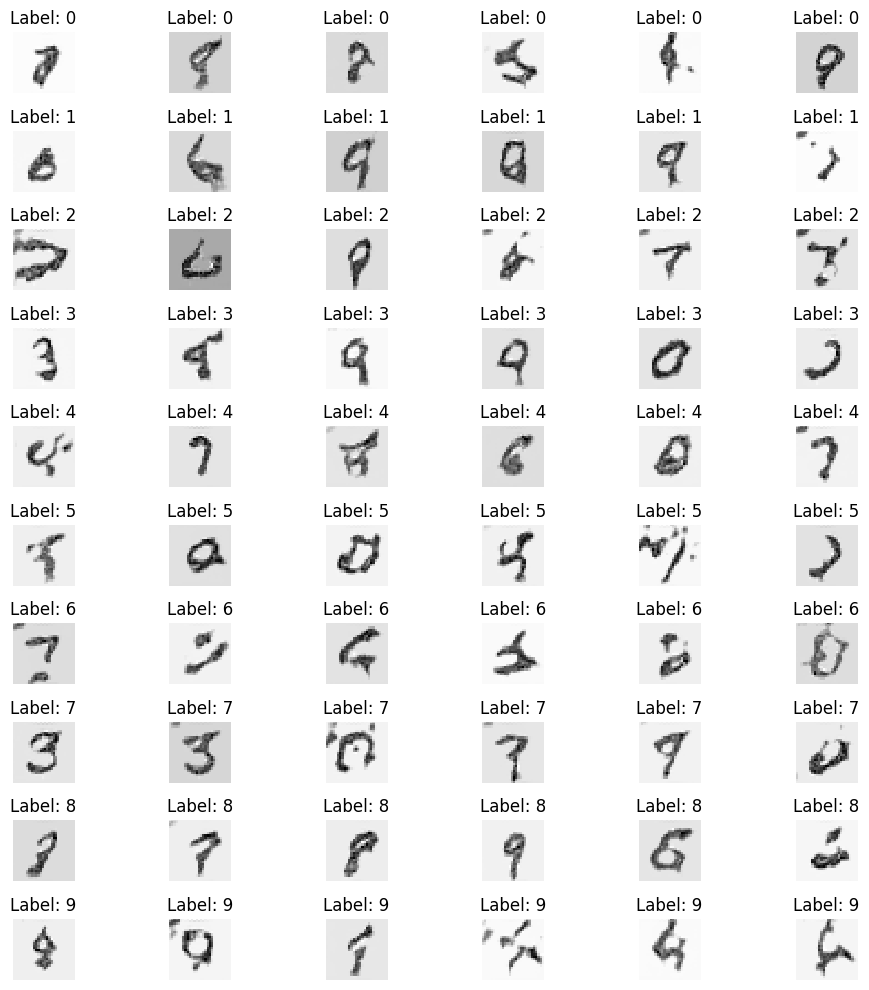

End of epoch 14, calling plot_imgs()


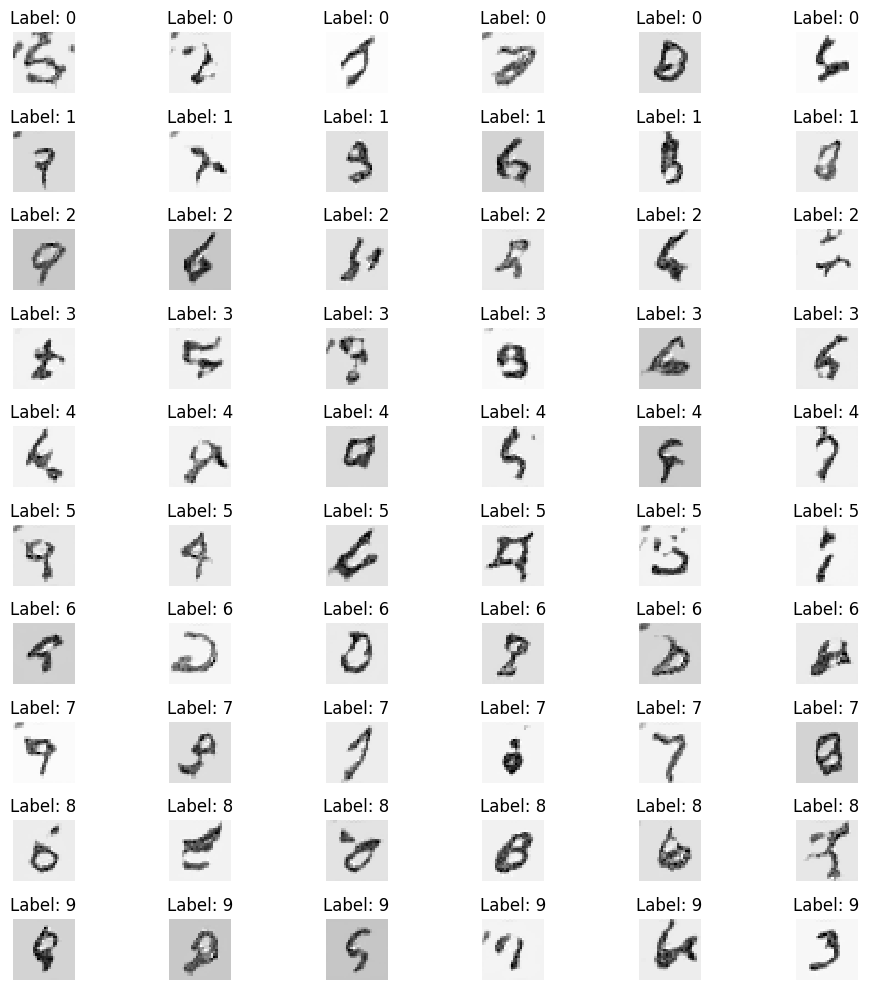

End of epoch 15, calling plot_imgs()


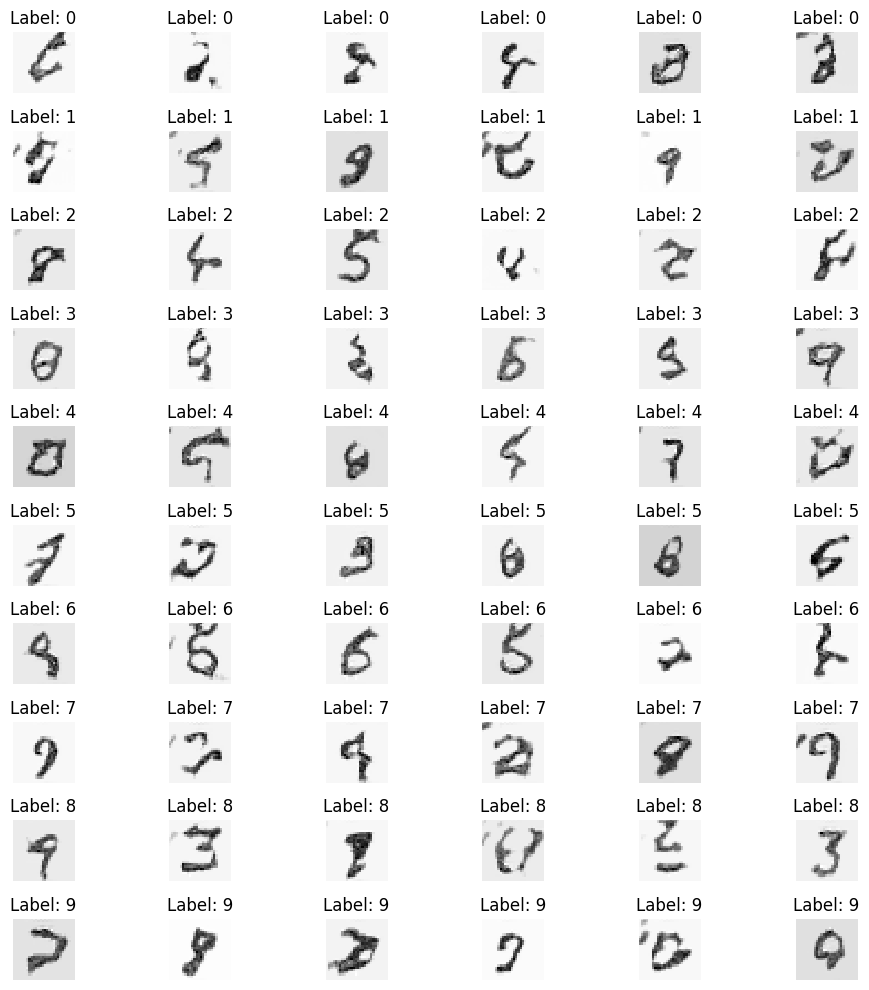

End of epoch 16, calling plot_imgs()


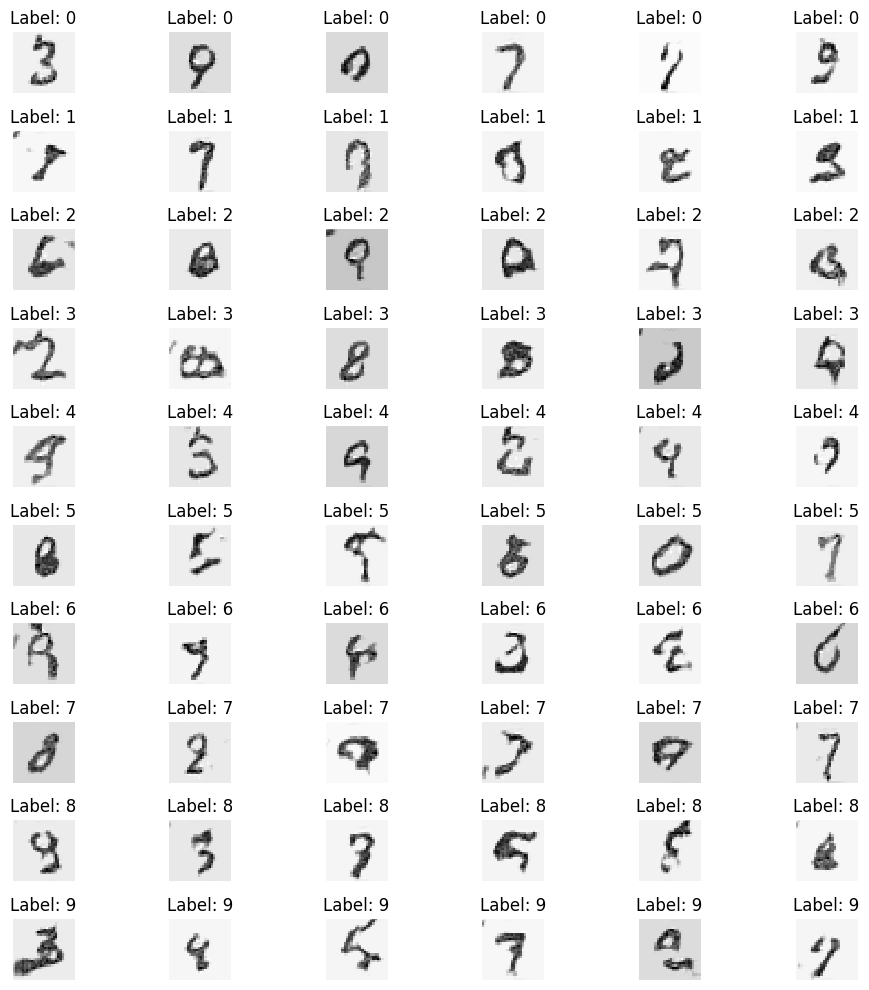

End of epoch 17, calling plot_imgs()


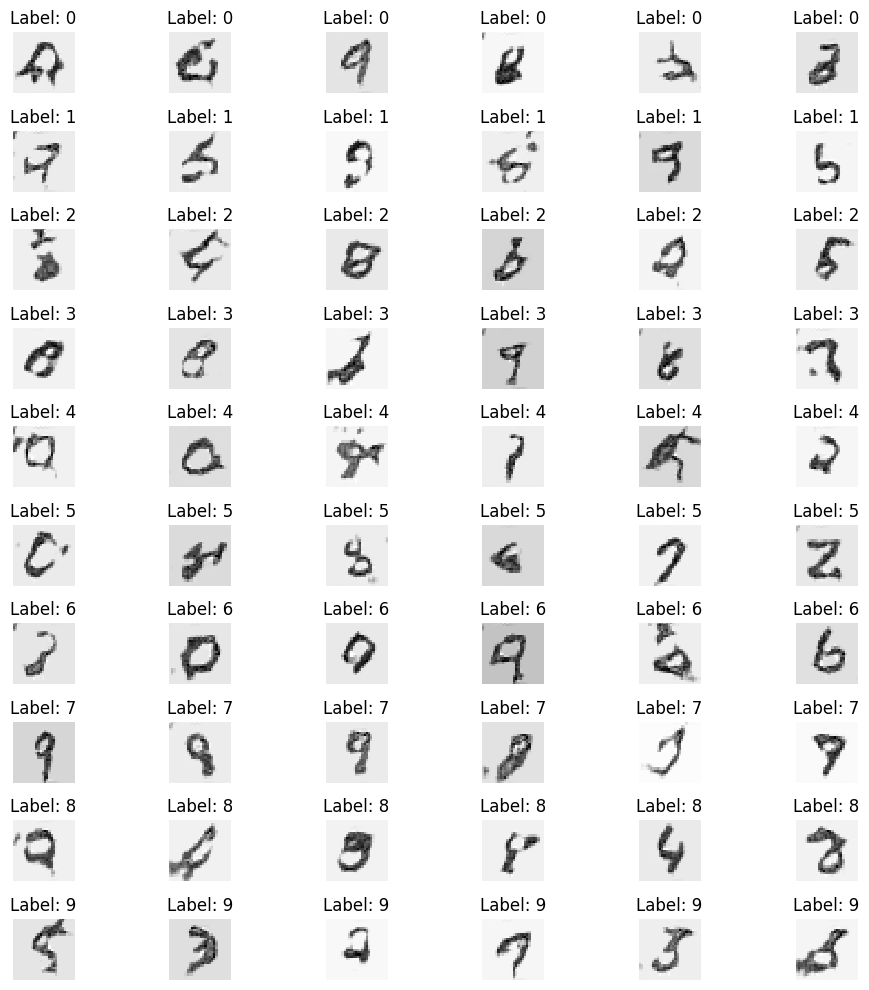

End of epoch 18, calling plot_imgs()


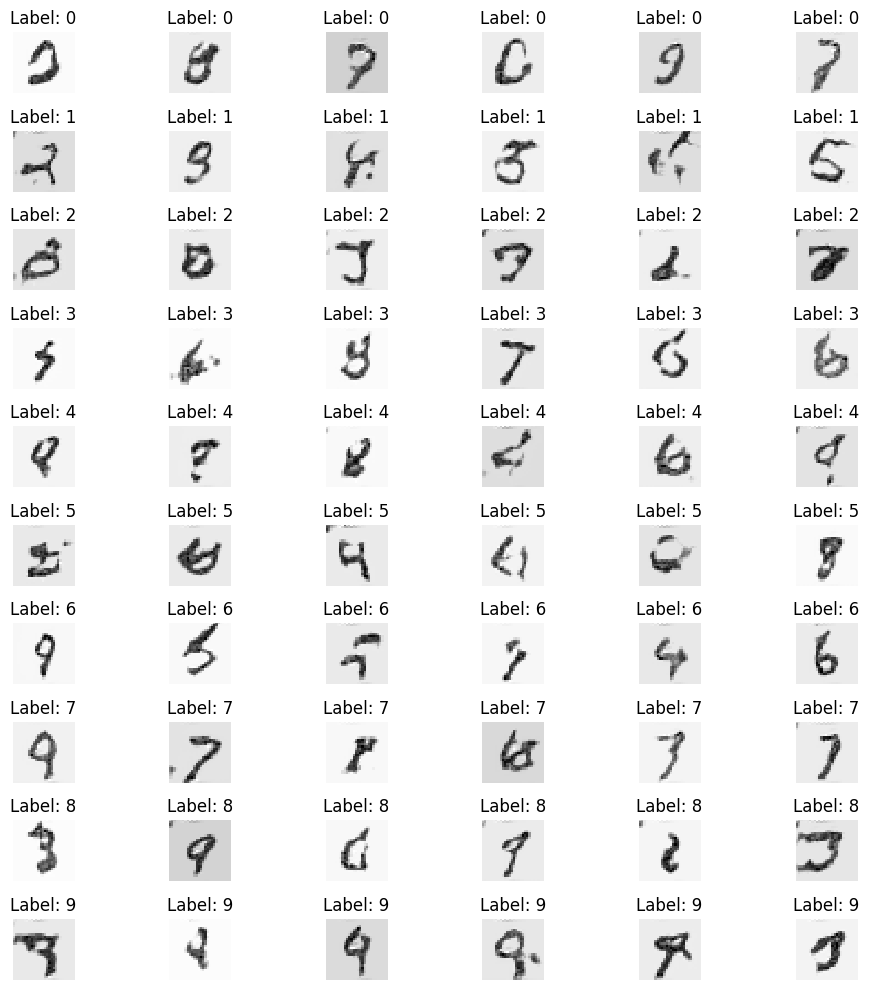

End of epoch 19, calling plot_imgs()


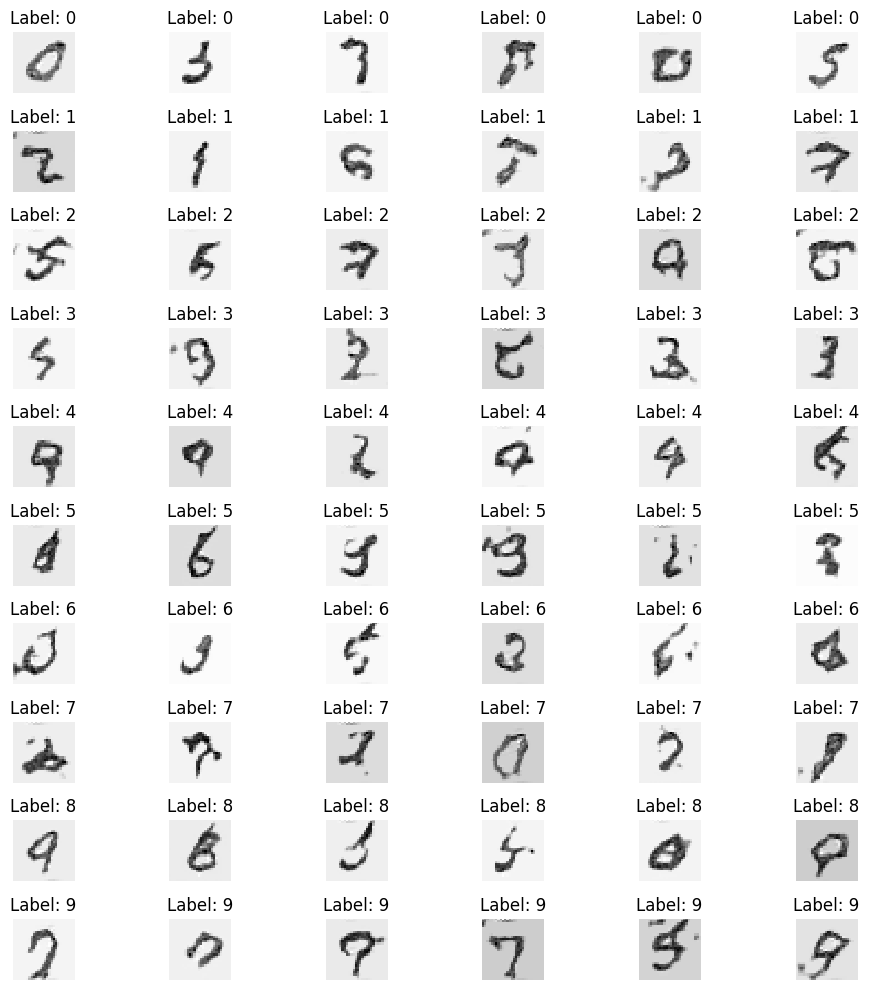

End of epoch 20, calling plot_imgs()


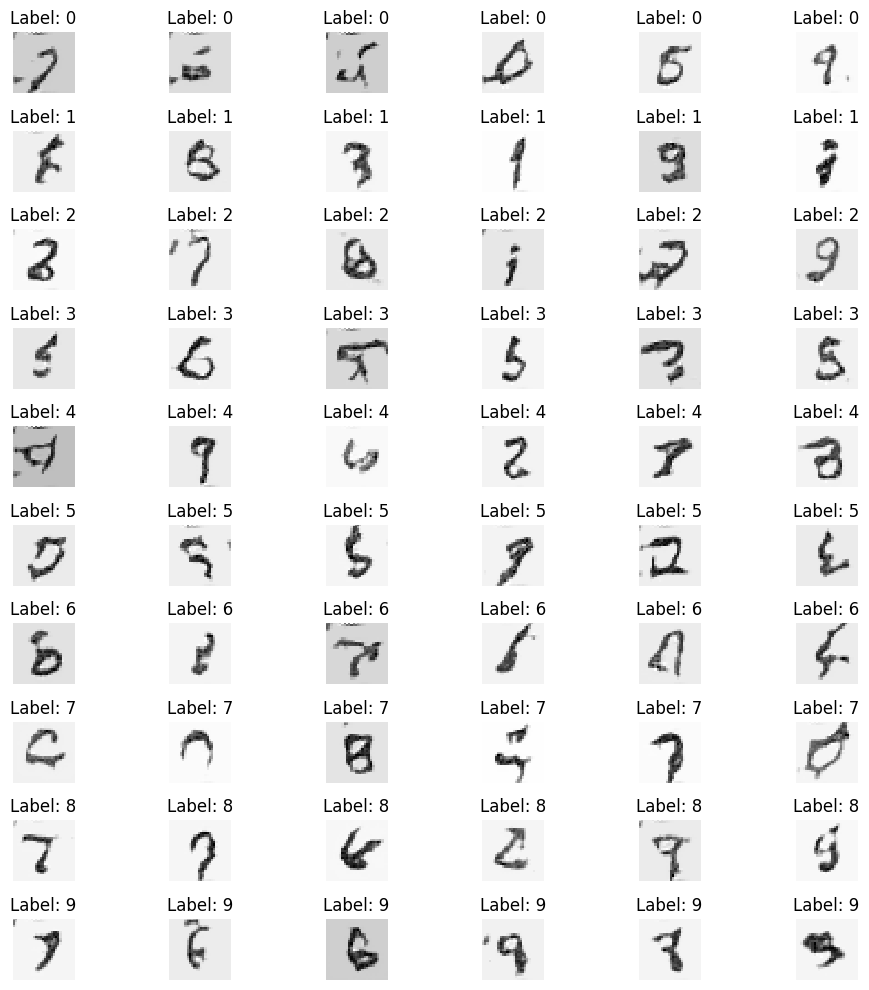

End of epoch 21, calling plot_imgs()


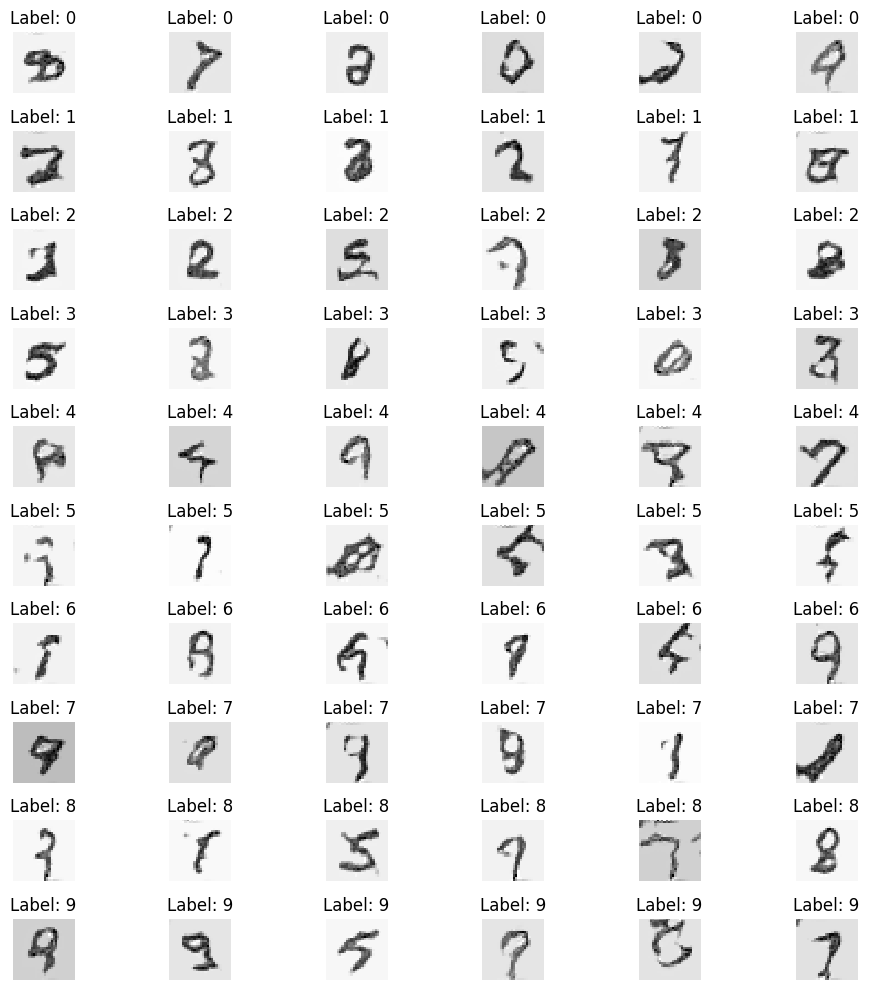

End of epoch 22, calling plot_imgs()


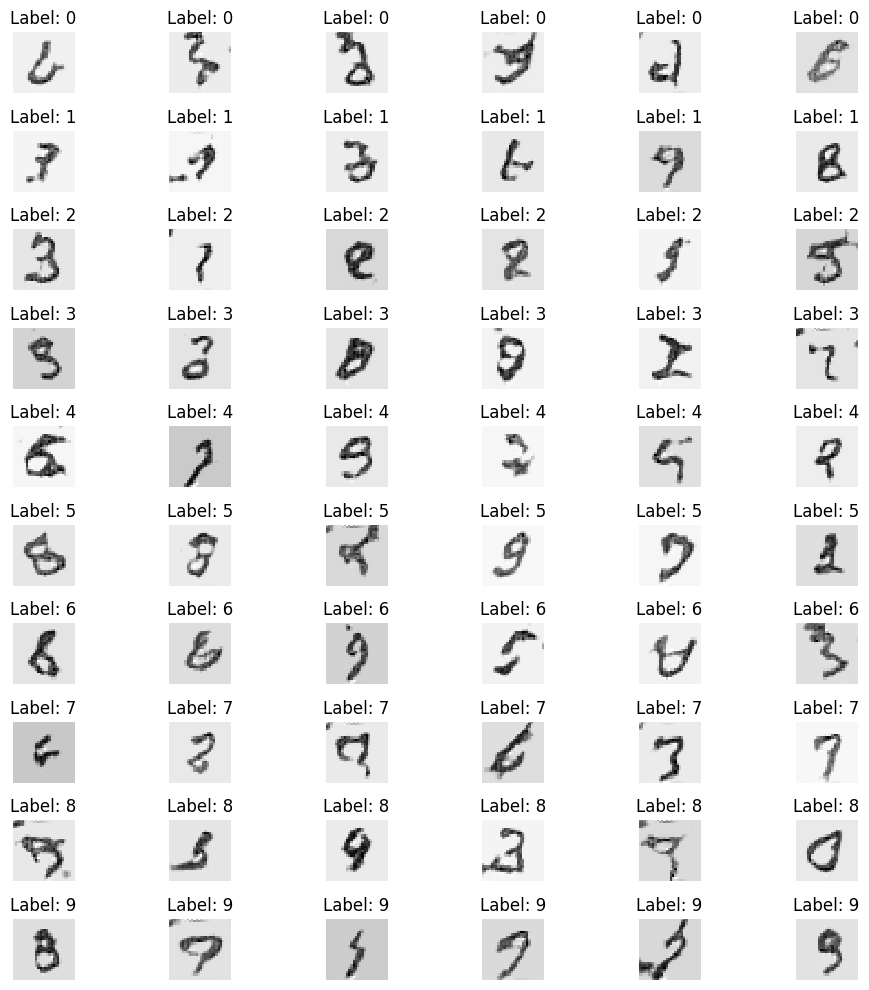

End of epoch 23, calling plot_imgs()


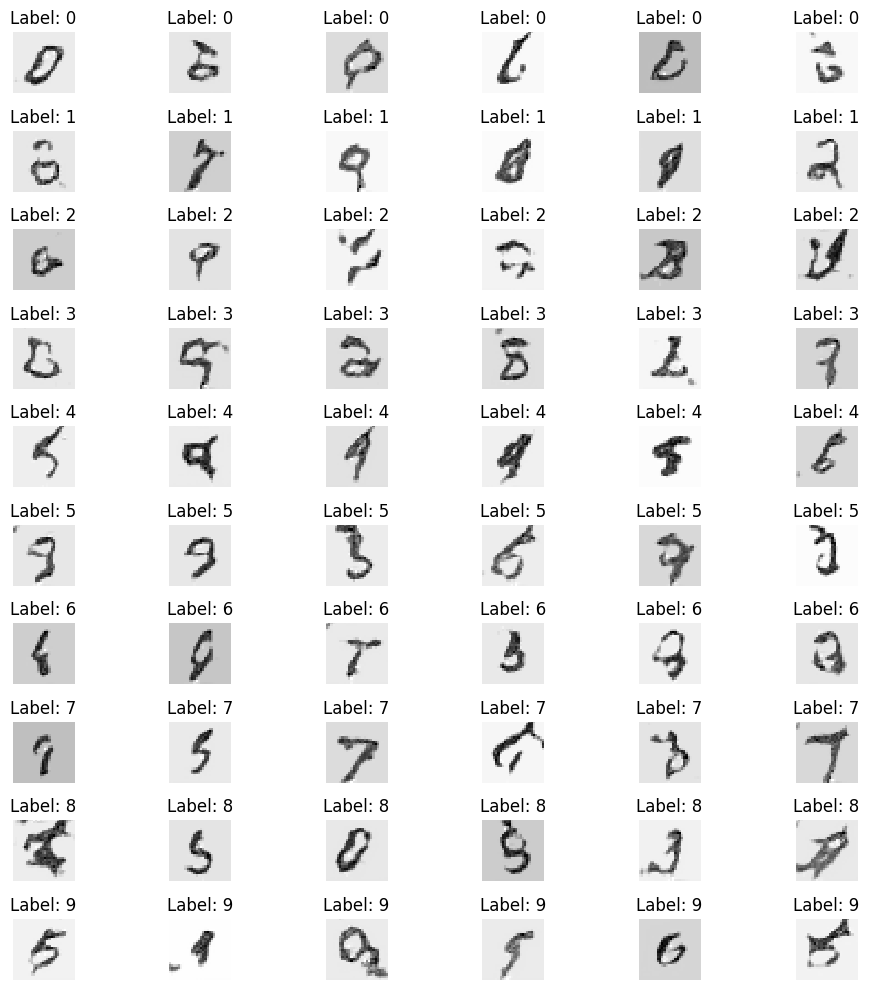

End of epoch 24, calling plot_imgs()


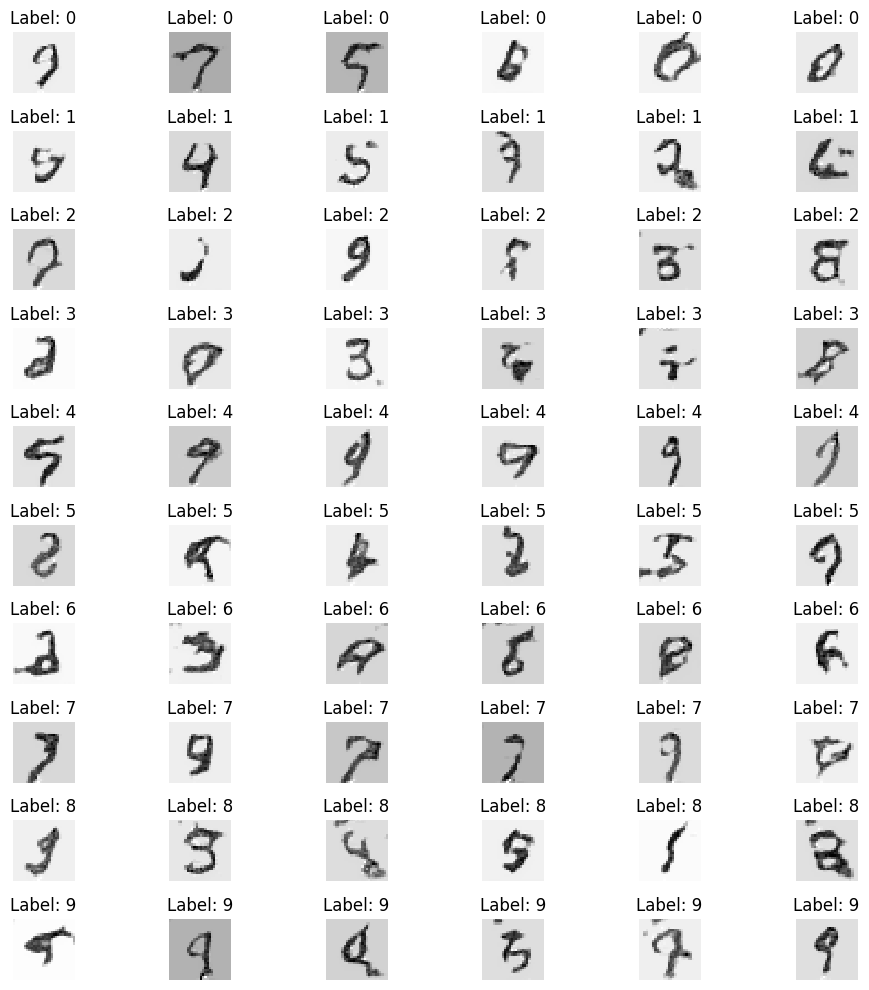

End of epoch 25, calling plot_imgs()


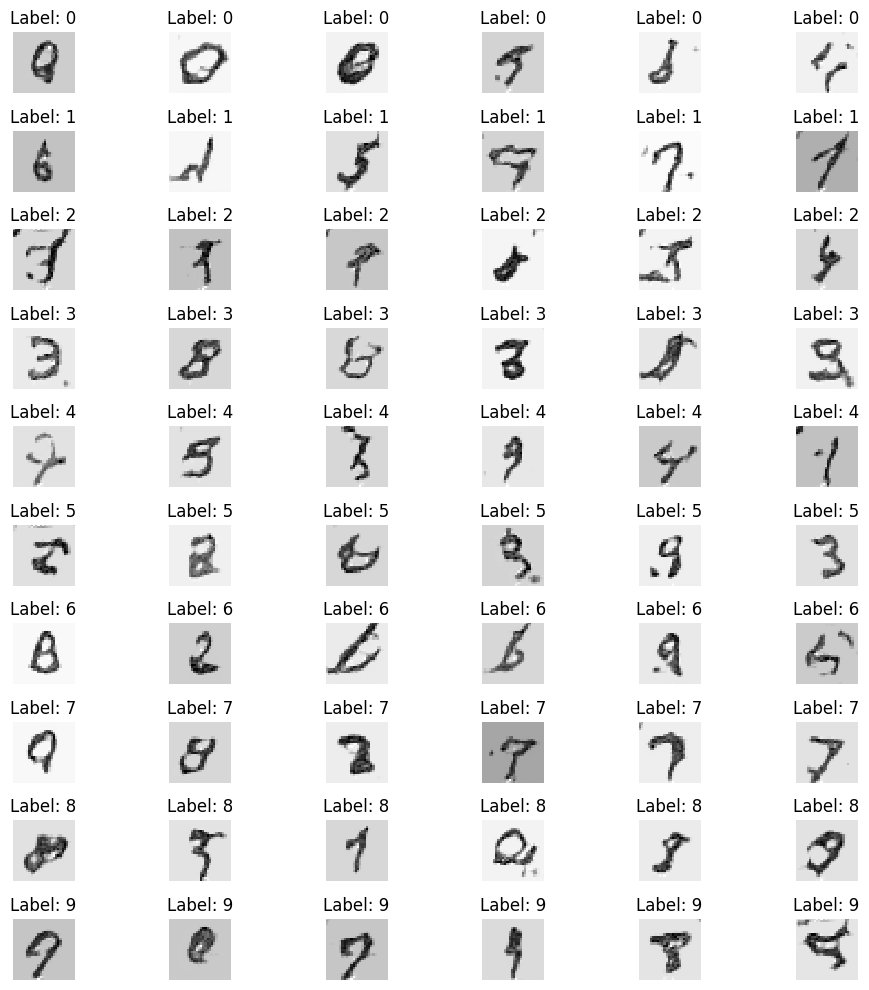

End of epoch 26, calling plot_imgs()


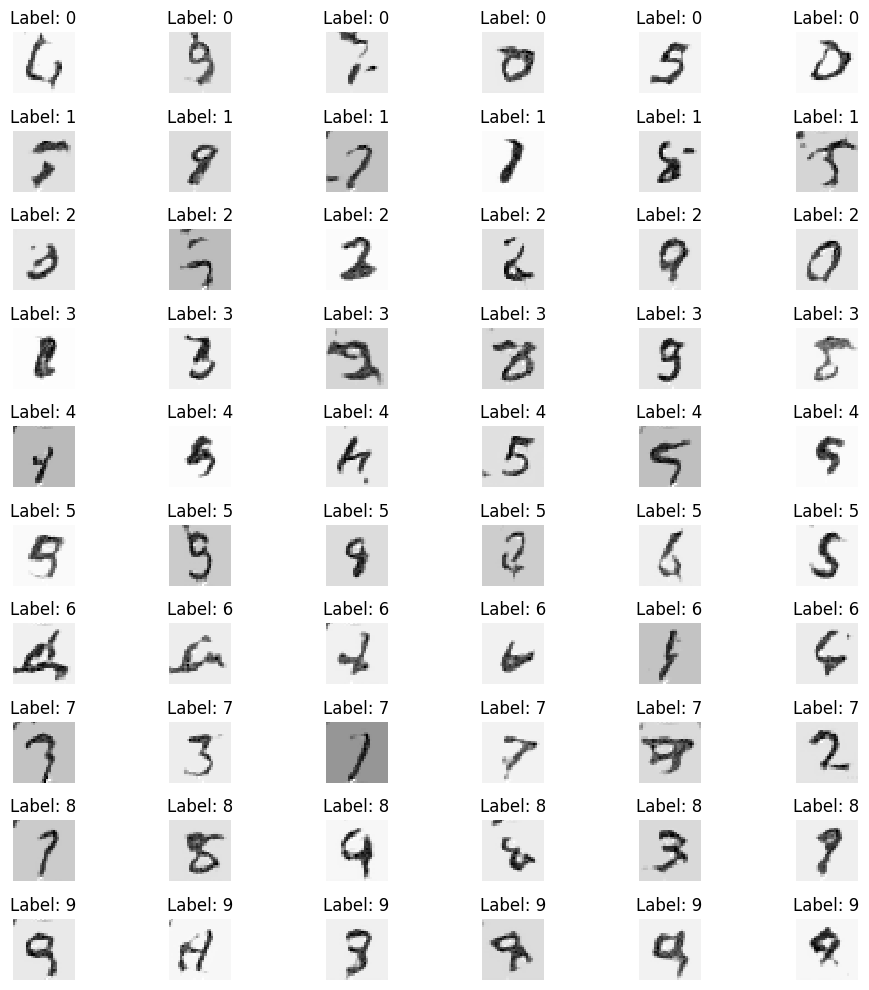

End of epoch 27, calling plot_imgs()


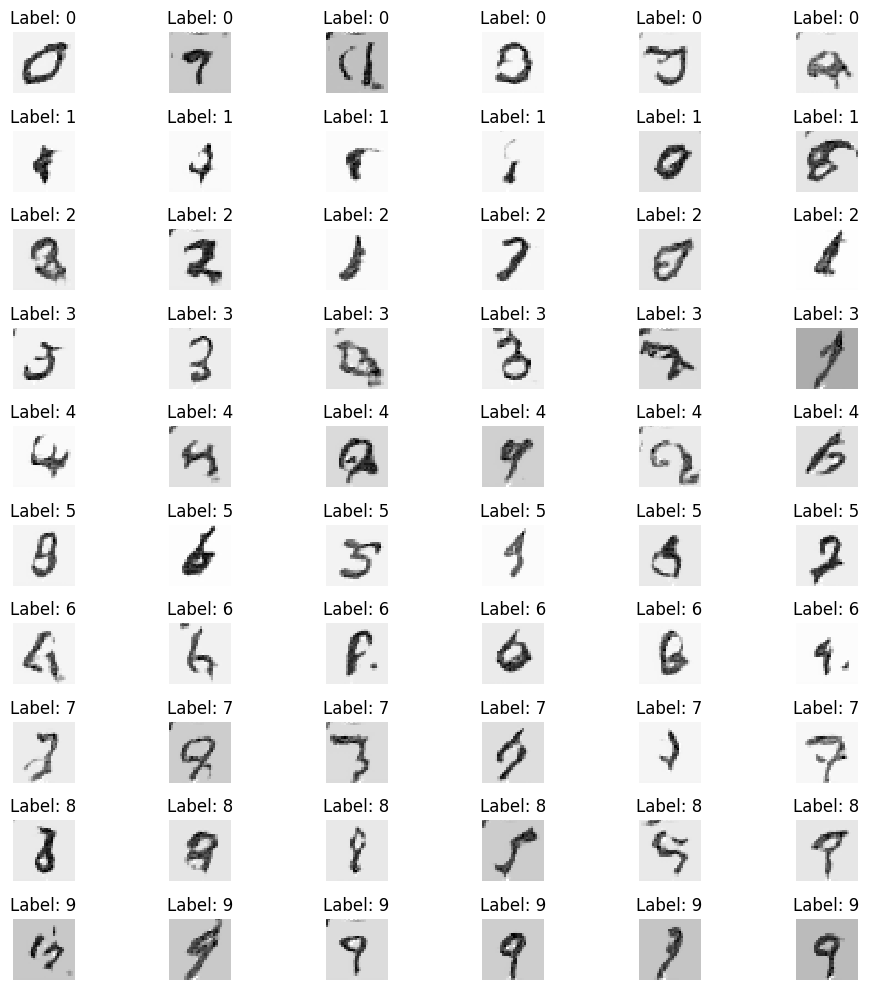

End of epoch 28, calling plot_imgs()


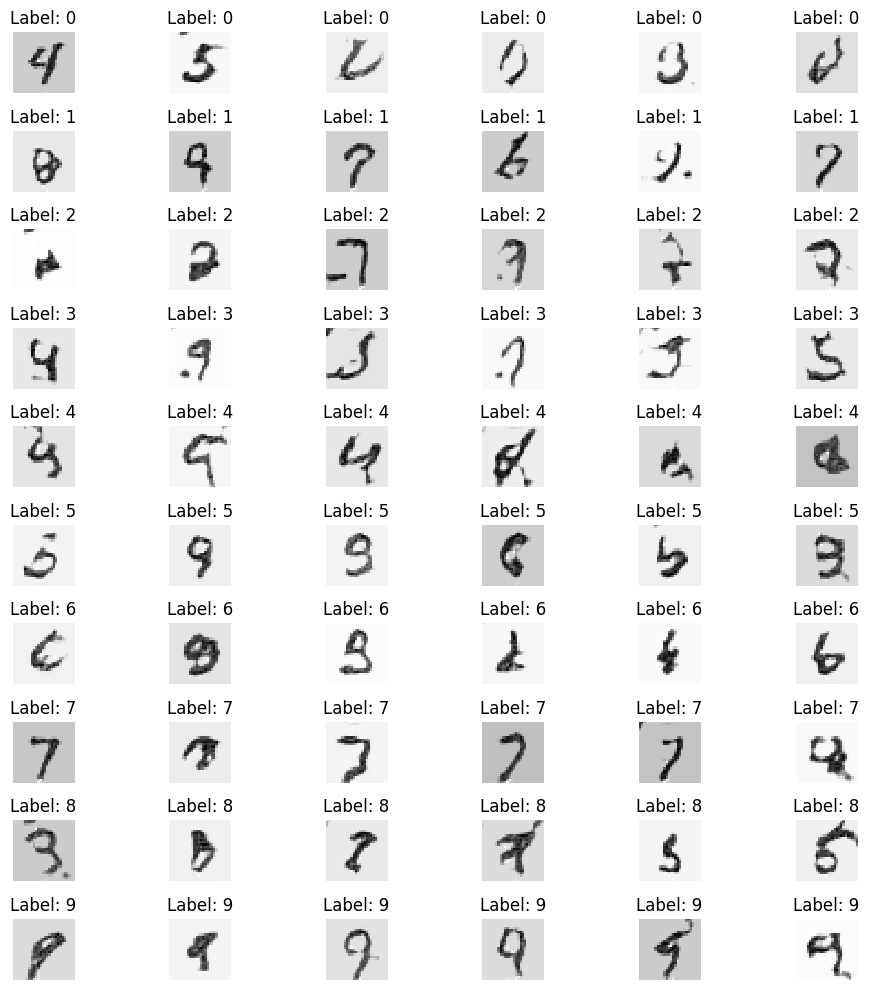

End of epoch 29, calling plot_imgs()


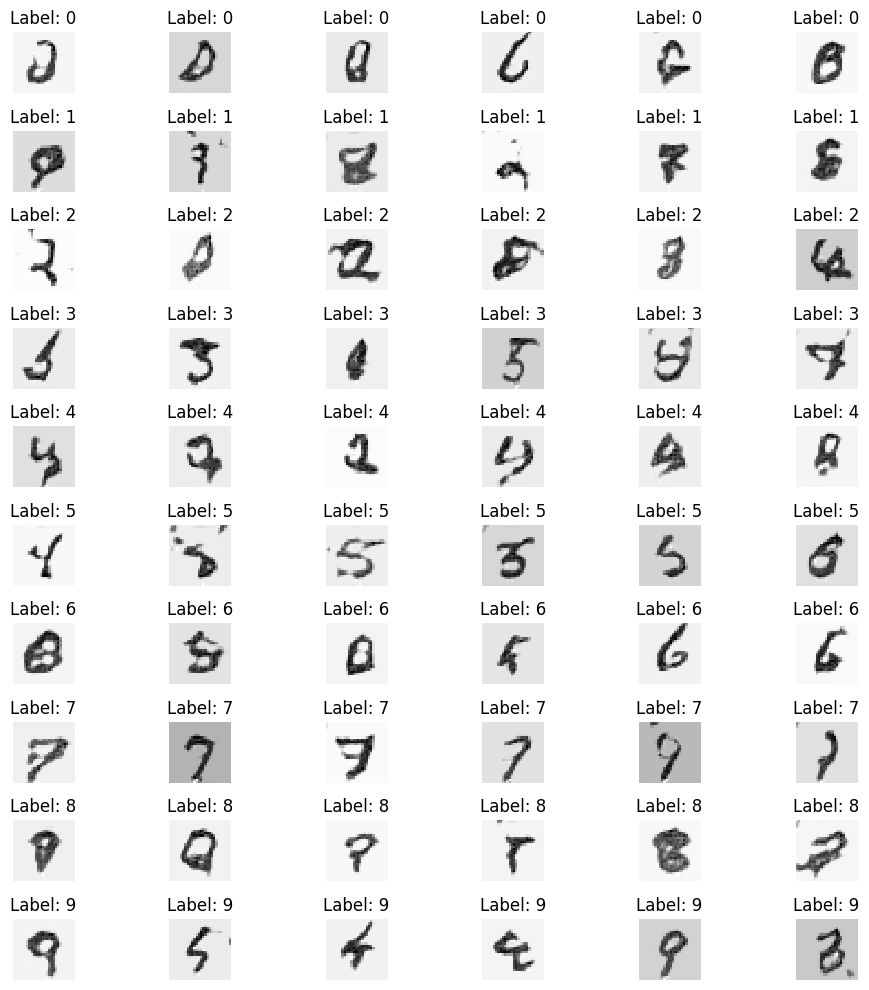

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
trainer = pl.Trainer(max_epochs=30, devices=AVAIL_GPUS)
trainer.fit(model, dm)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined